In [1]:
import pandas as pd
import math
import numpy as np
from sklearn import tree
import scipy.stats
from sklearn import preprocessing

In [2]:
team_name_all=["愛媛","横浜","岡山","岐阜","京都","金沢","熊本","甲府","山形","山口","讃岐","鹿児島","松本","湘南","新潟","水戸","千葉","群馬","大宮","大分","町田","長崎","東京","徳島","栃木","柏","福岡","名古屋","琉球"]
team_number_all=["37","34","42","39","24","275","38","28","29","330","48","338","46","12","78","94","2","35","27","31","45","47","4","36","40","11","23","8","277"]

In [3]:
all_team=[]
kion=[]
for i in range(29):
    team_name=team_name_all[i]
    team_number=team_number_all[i]
    url=f"https://data.j-league.or.jp/SFMS01/search?competition_years=2019&competition_years=2018&competition_years=2017&competition_frame_ids=2&team_ids={team_number}&home_away_select=1&tv_relay_station_name="
    fomerdata=pd.read_html(url,header=0)
    data=fomerdata[0].drop(["大会","スタジアム"],axis=1)
    game_day=data.試合日
    game_day=[s.replace("月・祝","月").replace("火・祝","火").replace("水・祝","水").replace("木・祝","木").replace("金・祝","金").replace("土・祝","土").replace("日・祝","日").replace("月・休","月") for s in game_day]
    day=data.年度.astype(str)+"/"+game_day
    day=pd.DataFrame({"年/月/日":day})
    data=pd.concat([data,day],axis=1)
    tenki=pd.read_excel(f"c:\\Users\\梅津魁秀\\Desktop\\卒業研究\\天気データ\\全国天気\\{team_name}.xlsx",skiprows=3)
    tenki=tenki.fillna(0)
    tenki=tenki.drop(tenki.index[[0]]).reset_index(drop=True)
    tenki=tenki.drop(tenki.index[1095])
    #1時間当たりの降水量情報を入れる
    tenki2=pd.read_excel(f"c:\\Users\\梅津魁秀\\Desktop\\卒業研究\\1時間降水量の日最大\\{team_name}1.xlsx",skiprows=3)
    tenki2=tenki2.drop(tenki2.index[[0,1,1097]]).reset_index(drop=True)
    tenki["1時間降水量の最大(mm)"]=tenki2["1時間降水量の最大(mm)"]
    google_trend=pd.read_csv("gt.csv").drop(["Unnamed: 0"],axis=1)
    google_trend=google_trend[f"{team_name}"]
    tenki=pd.concat([tenki,google_trend],axis=1)
    tenki=tenki.rename(columns={f"{team_name}":"ホームトレンド"})
    day2=tenki.年.round().astype(int).astype(str)+"/"+tenki.月.round().astype(int).astype(str).str.zfill(2)+"/"+tenki.日.round().astype(int).astype(str).str.zfill(2)+"("+tenki.曜日+")"
    day2=pd.DataFrame({"年/月/日":day2})
    tenki=pd.concat([tenki,day2],axis=1)
    data=pd.merge(data,tenki[["年/月/日","平均気温(℃)","降水量の合計(mm)","日照時間(時間)","ホームトレンド","1時間降水量の最大(mm)"]],on="年/月/日",how="left")
    sec=data.節.str.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))
    sec=sec.str.extract("(.+)節",expand=True).rename(columns={0:"節数"})
    data=pd.concat([data,sec],axis=1)
    rank=pd.read_csv("c:\\Users\\梅津魁秀\\anaconda3\\rank.csv").drop(["Unnamed: 0"],axis=1)
    rank2=rank.rename(columns={"アウェイ":"ホーム"})
    data=pd.merge(data,rank[["アウェイ","節数","年度","順位"]],on=["アウェイ","年度","節数"],how="left")
    data=pd.merge(data,rank2[["ホーム","節数","年度","順位"]],on=["ホーム","年度","節数"],how="left")
    data=data.rename(columns={"順位_x":"アウェイ順位","順位_y":"ホーム順位"})
    data["節数"]=data["節数"].str.replace('第', '')
    data["K/O時刻"]=data["K/O時刻"].str[:2]
    score=data.スコア.str.split('-', expand=True)
    score=score[[0,1]].astype(np.int64)
    data["点数(ホームーアウェイ)"]=score[0]-score[1]
    data=data.drop(["年度","節","試合日","ホーム","インターネット中継・TV放送","年/月/日","アウェイ","スコア"],axis=1)
    #入場者数と平均気温に関しては、その地域ごとに偏差をとり、データに反映する。
#     visitors=int(data["入場者数"].mean())
    temperature＿mean=int(data["平均気温(℃)"].mean())
    kion.append({temperature＿mean:team_name})
    #それぞれ平均を引いた値を出力する。
    data["平均気温(℃)"]=round(data["平均気温(℃)"]-temperature＿mean,1)
    data["入場者数"]=preprocessing.scale(data["入場者数"])
#     data["入場者数"]=data["入場者数"]-visitors
    all_team.append(data)

In [4]:
#forループでリストにしっかり格納されたか個数をチェック(29個であれば成功)
print(len(all_team))
#リストを全て合わせてall_team_kanseiとする。
all_team_kansei=pd.concat(all_team)
#データを行方向でシャッフル
#再度reset_indexを↓で行うことで、行番号を再度設定する。
# all_team_kansei=all_team_kansei.sample(frac=1)
all_team_kansei=all_team_kansei.astype('float64').reset_index(drop=True)
# all_team_kansei.to_csv("a.csv")
all_team_kansei

29


,K/O時刻,入場者数,平均気温(℃),降水量の合計(mm),日照時間(時間),ホームトレンド,1時間降水量の最大(mm),節数,アウェイ順位,ホーム順位,点数(ホームーアウェイ)
0,15.0,1.602909,-11.2,0.0,4.9,51.0,0.0,1.0,16.0,6.0,1.0
1,15.0,0.032360,-9.1,0.0,4.7,50.0,0.0,2.0,19.0,8.0,0.0
2,15.0,-0.082965,-8.0,0.0,10.7,28.0,0.0,4.0,1.0,14.0,-1.0
3,15.0,0.124165,-2.3,0.5,1.6,51.0,0.5,7.0,20.0,12.0,1.0
4,15.0,-1.003292,-1.8,0.0,10.4,38.0,0.0,9.0,9.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1381,19.0,-0.965138,3.1,8.5,0.6,35.0,5.5,31.0,20.0,15.0,1.0
1382,19.0,-0.793780,2.5,0.0,3.9,20.0,0.0,33.0,2.0,15.0,0.0
1383,18.0,-0.062424,2.3,0.0,6.2,33.0,0.0,36.0,13.0,15.0,-4.0
1384,13.0,1.296536,-0.7,0.0,3.4,100.0,0.0,38.0,4.0,15.0,-1.0


In [5]:
#説明変数となるものをそれぞれx1~x9まで作成
x1=np.array(all_team_kansei["1時間降水量の最大(mm)"])
x2=np.array(all_team_kansei["平均気温(℃)"])
x3=np.array(all_team_kansei["降水量の合計(mm)"])
x4=np.array(all_team_kansei["日照時間(時間)"])
x5=np.array(all_team_kansei["節数"])
x6=np.array(all_team_kansei["アウェイ順位"])
x7=np.array(all_team_kansei["ホーム順位"])
x8=np.array(all_team_kansei["点数(ホームーアウェイ)"])
x9=np.array(all_team_kansei["ホームトレンド"])
#目的変数(観客動員数)をyに入れる
# y=np.array(all_team_kansei["入場者数"])
# X=np.c_[x1,x2,x3,x4,x5,x6,x7,x8,x9]#SVRが使えるように変数を結合
# print(X.dtype,y.dtype)

In [6]:
#各項目を整理するために、ヒストグラムに出力する。
#標準化未実装
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties 
#日本語を表示するにはこうするらしい 
fp = FontProperties(fname=r'C:\WINDOWS\Fonts\msgothic.ttc', size=16) 

Counter({0.0: 906, 0.5: 72, 1.5: 45, 1.0: 43, 2.5: 32, 2.0: 32, 3.5: 26, 4.0: 23, 3.0: 23, 5.0: 19, 5.5: 19, 6.0: 16, 4.5: 15, 6.5: 14, 7.5: 7, 10.5: 7, 7.0: 7, 8.0: 6, 9.5: 6, 8.5: 6, 14.0: 6, 11.0: 5, 9.0: 5, 10.0: 4, 13.5: 4, 14.5: 4, 12.0: 3, 11.5: 3, 13.0: 2, 15.0: 2, 19.5: 2, 21.0: 2, 20.0: 2, 17.0: 2, 12.5: 2, 25.0: 1, 16.5: 1, 40.0: 1, 28.5: 1, 44.0: 1, 18.5: 1, 16.0: 1, 22.5: 1, 18.0: 1, 20.5: 1, 23.5: 1, 28.0: 1, 27.5: 1, 31.5: 1})
49


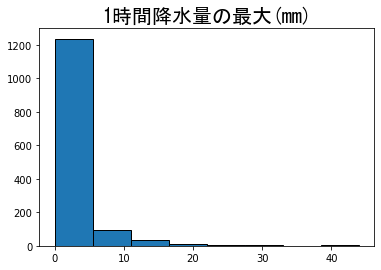

In [7]:
#x1と同様に他のデータも行うので、説明ここだけであとは省略する。
print(collections.Counter(x1))#種類とその個数を出力
print(len(collections.Counter(x1)))#種類数を出力
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x1, bins=8, histtype='barstacked', ec='black')#binで何個の棒の数を決める(今回は種類数にしている)
plt.title("1時間降水量の最大(mm)", fontsize=20,fontproperties=fp)
plt.show()

In [8]:
print(kion)

[{19: '愛媛'}, {19: '横浜'}, {19: '岡山'}, {20: '岐阜'}, {19: '京都'}, {18: '金沢'}, {21: '熊本'}, {19: '甲府'}, {16: '山形'}, {18: '山口'}, {19: '讃岐'}, {21: '鹿児島'}, {16: '松本'}, {19: '湘南'}, {18: '新潟'}, {17: '水戸'}, {19: '千葉'}, {18: '群馬'}, {19: '大宮'}, {19: '大分'}, {19: '町田'}, {20: '長崎'}, {19: '東京'}, {20: '徳島'}, {18: '栃木'}, {19: '柏'}, {20: '福岡'}, {19: '名古屋'}, {24: '琉球'}]


Counter({3.7: 16, 1.9: 15, 2.4: 13, 1.4: 13, -1.8: 12, 2.3: 12, 0.0: 12, -1.1: 12, -1.3: 11, 10.7: 11, 3.3: 11, -0.1: 11, -1.9: 11, 2.7: 11, -1.0: 11, -0.7: 11, 2.5: 10, -2.2: 10, 9.9: 10, 4.1: 10, 2.0: 10, 5.6: 10, -1.6: 10, 10.5: 9, 10.9: 9, -2.0: 9, 6.2: 9, 3.8: 9, -0.3: 9, -0.2: 9, 3.0: 9, 4.3: 9, 1.6: 9, -2.4: 9, 0.4: 8, 9.5: 8, -1.7: 8, -10.4: 8, -2.9: 8, 6.9: 8, 3.2: 8, 8.7: 8, 0.7: 8, -0.6: 8, 3.1: 8, 5.2: 8, 0.9: 8, 4.8: 8, 5.3: 8, 4.4: 8, -11.2: 7, 9.6: 7, -10.3: 7, -1.5: 7, 1.2: 7, 6.0: 7, 6.4: 7, 1.8: 7, -9.8: 7, 6.7: 7, -2.5: 7, -4.8: 7, 1.5: 7, 10.4: 7, 8.5: 7, 9.1: 7, -5.7: 7, 7.2: 7, -1.4: 7, -4.6: 7, 4.0: 7, 5.5: 7, 11.2: 7, 9.8: 6, -2.7: 6, 2.9: 6, -3.7: 6, 7.1: 6, 1.7: 6, -10.8: 6, -4.0: 6, -6.7: 6, -9.2: 6, -3.4: 6, 6.6: 6, 3.4: 6, -3.5: 6, 11.0: 6, 7.5: 6, -12.2: 6, 7.8: 6, 9.4: 6, 2.2: 6, -11.0: 6, -2.1: 6, 8.6: 6, 10.3: 6, -11.1: 6, 4.5: 6, 5.1: 6, -10.5: 6, -3.0: 6, -6.3: 6, -3.9: 6, 10.0: 6, 8.9: 6, 3.9: 6, 1.0: 6, -2.3: 5, 8.2: 5, -4.5: 5, -10.9: 5, -5.4: 5, 4

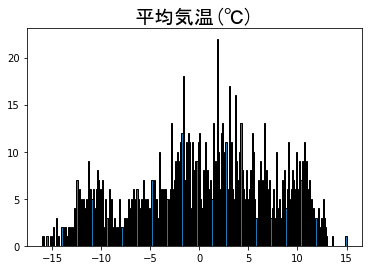

In [9]:
#データの編集が雑(入場者数にも言えるが)
print(collections.Counter(x2))
print(len(collections.Counter(x2)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x2, bins=284, histtype='barstacked', ec='black')
plt.title("平均気温(℃)", fontsize=20,fontproperties=fp)
plt.show()

Counter({0.0: 915, 0.5: 59, 1.0: 23, 2.0: 23, 1.5: 21, 2.5: 17, 3.5: 15, 3.0: 13, 9.0: 12, 6.0: 12, 4.5: 12, 4.0: 11, 8.5: 10, 5.0: 10, 6.5: 10, 5.5: 8, 7.5: 8, 10.0: 7, 14.0: 7, 15.0: 7, 7.0: 7, 13.0: 6, 14.5: 6, 11.5: 6, 16.0: 6, 16.5: 5, 12.0: 5, 11.0: 5, 8.0: 5, 29.5: 5, 19.5: 5, 18.5: 5, 20.0: 4, 39.0: 4, 10.5: 4, 27.0: 4, 15.5: 4, 23.5: 4, 17.0: 4, 12.5: 4, 25.0: 3, 9.5: 3, 20.5: 3, 17.5: 3, 13.5: 3, 25.5: 3, 29.0: 3, 41.0: 2, 46.0: 2, 18.0: 2, 80.0: 2, 60.0: 2, 19.0: 2, 30.0: 2, 31.0: 2, 21.0: 2, 36.5: 2, 43.0: 2, 21.5: 2, 22.5: 2, 35.0: 2, 24.0: 2, 30.5: 1, 22.0: 1, 63.0: 1, 46.5: 1, 98.5: 1, 59.0: 1, 40.0: 1, 28.5: 1, 110.5: 1, 82.0: 1, 91.5: 1, 44.0: 1, 45.5: 1, 23.0: 1, 126.0: 1, 65.0: 1, 38.0: 1, 124.5: 1, 66.5: 1, 34.5: 1, 39.5: 1, 32.5: 1, 47.0: 1, 66.0: 1, 88.5: 1, 37.5: 1, 28.0: 1, 93.5: 1, 33.5: 1, 53.5: 1, 26.5: 1, 56.5: 1, 44.5: 1, 24.5: 1, 55.0: 1, 92.0: 1, 32.0: 1})
138


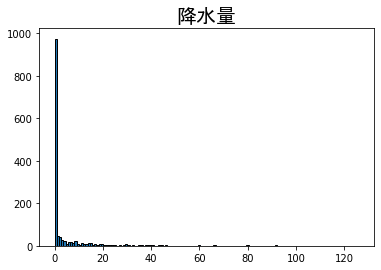

In [10]:
print(collections.Counter(x3))
print(len(collections.Counter(x4)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x3, bins=138, histtype='barstacked', ec='black')
plt.title("降水量", fontsize=20,fontproperties=fp)
plt.show()

Counter({0.0: 194, 0.1: 24, 9.7: 21, 9.5: 21, 0.6: 18, 11.3: 17, 6.7: 16, 10.2: 16, 11.7: 16, 9.3: 16, 0.5: 15, 9.4: 14, 0.4: 14, 0.3: 14, 10.4: 13, 9.1: 13, 11.1: 13, 0.2: 13, 8.3: 13, 11.2: 13, 8.5: 13, 12.3: 13, 9.6: 12, 6.8: 12, 6.6: 12, 11.5: 12, 12.5: 12, 7.7: 12, 10.7: 11, 1.6: 11, 8.0: 11, 1.7: 11, 12.1: 11, 10.3: 11, 10.0: 11, 8.8: 11, 2.6: 11, 0.7: 11, 7.3: 11, 2.9: 11, 3.4: 11, 3.9: 10, 10.6: 10, 5.3: 10, 9.8: 10, 8.7: 10, 9.0: 10, 12.2: 10, 5.8: 10, 6.1: 10, 3.6: 10, 12.0: 10, 8.1: 10, 11.4: 10, 4.7: 9, 10.1: 9, 8.9: 9, 8.4: 9, 13.0: 9, 7.6: 9, 5.9: 9, 6.9: 9, 8.6: 9, 0.8: 9, 9.2: 9, 9.9: 9, 5.7: 9, 7.1: 9, 11.0: 9, 10.8: 9, 7.2: 9, 11.9: 8, 12.4: 8, 4.8: 8, 13.1: 8, 7.8: 8, 12.7: 8, 5.6: 8, 12.8: 8, 12.6: 8, 6.5: 8, 7.0: 8, 2.1: 8, 3.0: 8, 1.0: 8, 4.1: 8, 10.9: 8, 1.8: 8, 3.2: 8, 11.6: 7, 11.8: 7, 2.4: 7, 4.5: 7, 4.4: 7, 6.2: 7, 7.9: 7, 5.0: 7, 1.3: 6, 10.5: 6, 1.9: 6, 2.8: 6, 4.0: 6, 1.4: 6, 6.0: 6, 7.4: 6, 4.9: 5, 2.7: 5, 3.7: 5, 1.1: 5, 3.3: 5, 3.5: 5, 3.1: 5, 8.2: 5, 5

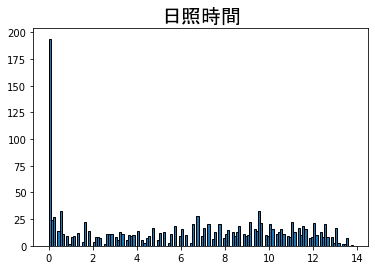

In [11]:
print(collections.Counter(x4))
print(len(collections.Counter(x4)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x4, bins=138, histtype='barstacked', ec='black')
plt.title("日照時間", fontsize=20,fontproperties=fp)
plt.show()

Counter({1.0: 33, 2.0: 33, 4.0: 33, 7.0: 33, 9.0: 33, 10.0: 33, 12.0: 33, 14.0: 33, 15.0: 33, 18.0: 33, 20.0: 33, 23.0: 33, 25.0: 33, 27.0: 33, 29.0: 33, 30.0: 33, 34.0: 33, 37.0: 33, 40.0: 33, 33.0: 33, 41.0: 33, 6.0: 33, 8.0: 33, 11.0: 33, 13.0: 33, 24.0: 33, 28.0: 33, 31.0: 33, 32.0: 33, 35.0: 33, 39.0: 33, 5.0: 33, 17.0: 33, 19.0: 33, 21.0: 33, 26.0: 33, 36.0: 33, 3.0: 33, 16.0: 33, 38.0: 33, 22.0: 33, 42.0: 33})
42


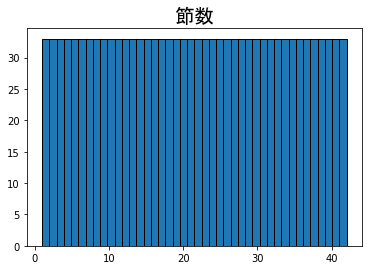

In [12]:
print(collections.Counter(x5))
print(len(collections.Counter(x5)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x5,bins=42, histtype='barstacked', ec='black')
plt.title("節数", fontsize=20,fontproperties=fp)
plt.show()

Counter({12.0: 70, 8.0: 70, 16.0: 67, 17.0: 67, 6.0: 67, 21.0: 67, 3.0: 66, 19.0: 65, 14.0: 65, 20.0: 64, 13.0: 64, 4.0: 63, 18.0: 63, 22.0: 62, 11.0: 61, 2.0: 61, 5.0: 60, 9.0: 59, 7.0: 59, 1.0: 56, 15.0: 56, 10.0: 54})
22


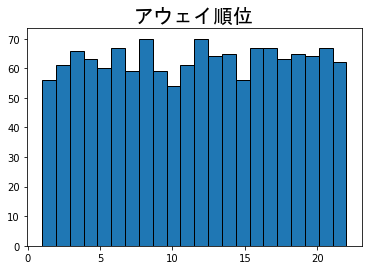

In [13]:
print(collections.Counter(x6))
print(len(collections.Counter(x6)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x6, bins=22, histtype='barstacked', ec='black')
plt.title("アウェイ順位", fontsize=20,fontproperties=fp)
plt.show()

Counter({1.0: 71, 10.0: 70, 15.0: 68, 11.0: 67, 5.0: 67, 7.0: 65, 18.0: 65, 4.0: 65, 13.0: 64, 16.0: 64, 22.0: 64, 9.0: 64, 2.0: 64, 6.0: 62, 3.0: 62, 8.0: 61, 21.0: 59, 19.0: 59, 20.0: 58, 17.0: 57, 14.0: 55, 12.0: 55})
22


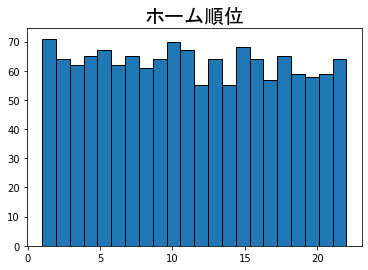

In [14]:
print(collections.Counter(x7))
print(len(collections.Counter(x7)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x7, bins=22, histtype='barstacked', ec='black')
plt.title("ホーム順位", fontsize=20,fontproperties=fp)
plt.show()

Counter({0.0: 357, 1.0: 325, -1.0: 298, 2.0: 138, -2.0: 106, 3.0: 57, -3.0: 44, 4.0: 29, -4.0: 17, 5.0: 9, -5.0: 2, 6.0: 2, -7.0: 1, 12.0: 1})
14


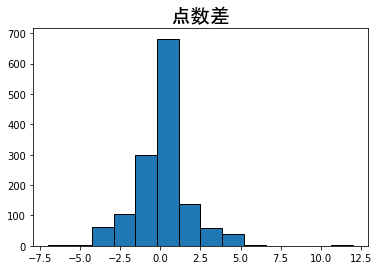

In [15]:
print(collections.Counter(x8))
print(len(collections.Counter(x8)))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x8, bins=14, histtype='barstacked', ec='black')
plt.title("点数差", fontsize=20,fontproperties=fp)
plt.show()

Counter({30.0: 49, 27.0: 40, 33.0: 36, 20.0: 36, 29.0: 34, 24.0: 33, 42.0: 32, 39.0: 32, 34.0: 30, 51.0: 29, 32.0: 29, 53.0: 29, 26.0: 29, 28.0: 28, 36.0: 28, 41.0: 28, 23.0: 28, 37.0: 27, 19.0: 27, 22.0: 27, 45.0: 26, 31.0: 26, 17.0: 26, 21.0: 26, 25.0: 26, 35.0: 25, 46.0: 25, 15.0: 25, 16.0: 25, 40.0: 24, 18.0: 24, 13.0: 24, 14.0: 24, 44.0: 24, 48.0: 23, 54.0: 22, 52.0: 20, 50.0: 18, 38.0: 17, 47.0: 16, 43.0: 16, 56.0: 16, 63.0: 14, 55.0: 13, 10.0: 13, 12.0: 12, 100.0: 12, 49.0: 12, 60.0: 10, 11.0: 10, 66.0: 10, 57.0: 10, 67.0: 9, 62.0: 9, 9.0: 9, 61.0: 8, 58.0: 8, 64.0: 6, 70.0: 6, 68.0: 6, 59.0: 6, 65.0: 5, 75.0: 5, 84.0: 5, 69.0: 4, 78.0: 4, 73.0: 4, 77.0: 4, 76.0: 4, 71.0: 4, 74.0: 4, 8.0: 4, 81.0: 3, 97.0: 3, 90.0: 3, 87.0: 2, 86.0: 2, 83.0: 2, 82.0: 2, 79.0: 2, 72.0: 1, 91.0: 1, 85.0: 1, 80.0: 1, 94.0: 1, 99.0: 1, 7.0: 1, 96.0: 1})


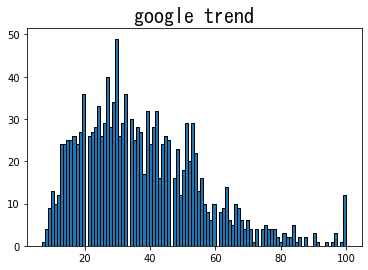

In [16]:
print(collections.Counter(x9))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(x9, bins=100, histtype='barstacked', ec='black')
plt.title("google trend", fontsize=20,fontproperties=fp)
plt.show()

範囲設定

x11時間降水量の最大(mm)：x1<1,1<=x1\
x2平均気温：-10<x2<10,それ以外\
x5節数：x2<14,14<=x2<28,28<=x2\
x6アウェイ順位：x6<8,8<=x6<15,15<=x6\
x7ホーム順位：x6<8,8<=x6<15,15<=x6\
x9トレンド情報：x9<34,34<=x9<67,67<=x9

In [17]:
#周辺化準備
#データ数1386、3^6=729、3^7=2187であるので、説明変数は6項目がベスト
#K/O時刻で検証
#参考資料　https://www.gesource.jp/weblog/?p=8244
#使うのはx1,x2,x5,x6,x7,x9
#x1のみについて説明する（以下同順）
#judge_x〇について、digitize()では0,1判定（もしくは0,1,2判定）であったが、
#関数に組み込むため、1,2判定（もしくは1,2,3判定）とする。
plus_list=[1]*1386
# np.set_printoptions(threshold=np.inf)
print(x1)#x1の中身を出力。
r_x1=np.array([1])
#分類範囲を決める(例：[1,3]の場合はx<1,1<=x<3,3<=xの3種類に分類できる。)範囲の個数？を増やせば分類個数を増やすことも可能。
judge_x1=np.digitize(x1,r_x1)#実際に決めた範囲を用いてx1を分類し、judge_x1とする。
judge_x1=judge_x1+plus_list
print(judge_x1)#judge_x1の中身を出力。

[0. 0. 0. ... 0. 0. 0.]
[1 1 1 ... 1 1 1]


In [18]:
#x2に関して
#絶対値±10以下の場合は1、以上の場合は2とする。
print(x2)
x2_abs=abs(x2)
print(x2_abs)
r_x2=np.array([10])
judge_x2=np.digitize(x2_abs,r_x2)
judge_x2=judge_x2+plus_list
print(judge_x2)
print(collections.Counter(judge_x2))

[-11.2  -9.1  -8.  ...   2.3  -0.7  -2.3]
[11.2  9.1  8.  ...  2.3  0.7  2.3]
[2 1 1 ... 1 1 1]
Counter({1: 1114, 2: 272})


In [19]:
#x5~x9までx1と同様の作業を行う
print(x5)
r_x5=np.array([14,28])
judge_x5=np.digitize(x5,r_x5)
judge_x5=judge_x5+plus_list
print(judge_x5)
print(x6)
r_x6=np.array([8,15])
judge_x6=np.digitize(x6,r_x6)
judge_x6=judge_x6+plus_list
print(judge_x6)
print(x7)
r_x7=np.array([8,15])
judge_x7=np.digitize(x7,r_x7)
judge_x7=judge_x7+plus_list
print(judge_x7)
print(x9)
r_x9=np.array([34,67])
judge_x9=np.digitize(x9,r_x9)
judge_x9=judge_x9+plus_list
print(judge_x9)

[ 1.  2.  4. ... 36. 38. 40.]
[1 1 1 ... 3 3 3]
[16. 19.  1. ... 13.  4.  8.]
[3 3 1 ... 2 1 2]
[ 6.  8. 14. ... 15. 15. 15.]
[1 2 2 ... 3 3 3]
[ 51.  50.  28. ...  33. 100.  43.]
[2 2 1 ... 1 3 2]


In [20]:
#x1~x9までそれぞれの項目について分類したので、それを結合し、1386データを729グループに分類する。
#判定結果をstr(文字列)に直し、縦方向でつなげる。
classification=[]
for t in range(len(judge_x1)):
    classification.append(str(judge_x1[t])+str(judge_x2[t])+str(judge_x5[t])
             +str(judge_x6[t])+str(judge_x7[t])+str(judge_x9[t]))

print(len(classification))    
print(classification)

1386
['121312', '111322', '111121', '111322', '111222', '111222', '111322', '112313', '112123', '212312', '212122', '112223', '122232', '112232', '113321', '113121', '113131', '213332', '113132', '213332', '113332', '221122', '121233', '111232', '121232', '111332', '111232', '211132', '112332', '212131', '212332', '122333', '122233', '122132', '123132', '213332', '213331', '113131', '213332', '113131', '113132', '113132', '121222', '221312', '111321', '121221', '111232', '111322', '111332', '211132', '111332', '112132', '112132', '112132', '112133', '112232', '122232', '113123', '113222', '113332', '113233', '113332', '113233', '121311', '121311', '121111', '211311', '211311', '111211', '112311', '112111', '112311', '112111', '212111', '112311', '112111', '212111', '213211', '113311', '213211', '213121', '213321', '113321', '113221', '121221', '111311', '121121', '111221', '111221', '111221', '111311', '112311', '112311', '112311', '212211', '212211', '122211', '122111', '113311', '213

In [47]:
print(collections.Counter(classification))#先程と同様に種類とその数を出力
cf=list(set(classification))
print(cf)#リスト内の重複を削除
print(len(cf))#重複を削除後のデータ数を出力

Counter({'113311': 26, '112321': 23, '113332': 22, '113321': 21, '113132': 21, '112311': 21, '113221': 19, '111132': 18, '111311': 17, '112232': 16, '113312': 16, '213332': 15, '111232': 15, '112332': 15, '111321': 15, '213211': 15, '112322': 15, '112312': 15, '113322': 15, '113232': 15, '112211': 15, '212211': 14, '113111': 14, '113122': 14, '112231': 14, '113121': 13, '113131': 13, '111211': 13, '112111': 13, '111131': 13, '113212': 13, '111231': 13, '112131': 13, '121312': 12, '111332': 12, '111312': 12, '112121': 12, '113211': 11, '112222': 11, '111331': 11, '111121': 10, '111222': 10, '122232': 10, '113222': 10, '213121': 10, '112112': 10, '213132': 10, '213232': 10, '113331': 10, '113231': 10, '213221': 10, '111212': 10, '111322': 9, '213321': 9, '111221': 9, '213111': 9, '112212': 9, '212331': 9, '212312': 8, '211132': 8, '212131': 8, '212332': 8, '122132': 8, '112132': 8, '212111': 8, '213311': 8, '213222': 8, '112122': 8, '113133': 8, '121211': 8, '212121': 8, '212321': 8, '21

In [48]:
# cfに格納された6桁の数字を1桁ずつ分解してリストへ（新たな説明変数となる）（y1~y6）。

y1=[]#1時間当たりの降水量
y2=[]#気温
y3=[]#節数
y4=[]#アウェイ順位
y5=[]#ホーム順位
y6=[]#トレンド情報

for i in cf:
    y1.append(i[0])
    y2.append(i[1])
    y3.append(i[2])
    y4.append(i[3])
    y5.append(i[4])
    y6.append(i[5])

#例として、y1を出力
print(y1)
print(len(y1))

['2', '2', '1', '2', '2', '2', '1', '2', '2', '2', '2', '1', '2', '1', '2', '2', '2', '1', '1', '1', '2', '1', '1', '2', '1', '1', '1', '2', '1', '1', '2', '2', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '1', '2', '1', '1', '2', '2', '1', '1', '2', '2', '1', '2', '1', '1', '2', '2', '2', '1', '2', '1', '1', '2', '1', '2', '1', '2', '1', '1', '1', '2', '1', '1', '2', '1', '2', '1', '2', '1', '1', '2', '2', '2', '1', '2', '1', '1', '1', '2', '1', '2', '2', '1', '1', '1', '1', '2', '2', '1', '2', '1', '2', '1', '1', '2', '2', '1', '1', '1', '1', '2', '2', '1', '2', '2', '1', '1', '2', '1', '2', '2', '2', '1', '1', '1', '2', '2', '1', '2', '1', '2', '1', '2', '1', '1', '2', '1', '2', '1', '1', '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '2', '2', '1', '1', '2', '1', '1', '1', '2', '2', '1', '1', '2', '1', '2', '1', '1', '1', '2', '2', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '2', '1', '1', '1', '1', '1', '2', '1', '1', '1', '1', '1', '1', '1', '2', '1',

In [49]:
#元のデータ（all_team_kansei）のdataframeに6桁で判定したデータ（classification）を列として追加
print(classification[:5])

all_team_kansei["judge"]=classification
all_team_kansei

['121312', '111322', '111121', '111322', '111222']


,K/O時刻,入場者数,平均気温(℃),降水量の合計(mm),日照時間(時間),ホームトレンド,1時間降水量の最大(mm),節数,アウェイ順位,ホーム順位,点数(ホームーアウェイ),judge
0,15.0,1.602909,-11.2,0.0,4.9,51.0,0.0,1.0,16.0,6.0,1.0,121312
1,15.0,0.032360,-9.1,0.0,4.7,50.0,0.0,2.0,19.0,8.0,0.0,111322
2,15.0,-0.082965,-8.0,0.0,10.7,28.0,0.0,4.0,1.0,14.0,-1.0,111121
3,15.0,0.124165,-2.3,0.5,1.6,51.0,0.5,7.0,20.0,12.0,1.0,111322
4,15.0,-1.003292,-1.8,0.0,10.4,38.0,0.0,9.0,9.0,13.0,1.0,111222
...,...,...,...,...,...,...,...,...,...,...,...,...
1381,19.0,-0.965138,3.1,8.5,0.6,35.0,5.5,31.0,20.0,15.0,1.0,213332
1382,19.0,-0.793780,2.5,0.0,3.9,20.0,0.0,33.0,2.0,15.0,0.0,113131
1383,18.0,-0.062424,2.3,0.0,6.2,33.0,0.0,36.0,13.0,15.0,-4.0,113231
1384,13.0,1.296536,-0.7,0.0,3.4,100.0,0.0,38.0,4.0,15.0,-1.0,113133


In [50]:
# all_team_kanseiについて、列judgeの値ごとに入場者の平均を求める。
# 全cfデータごとに平均を求めてリストvisitorsに格納する。
#観客動員数の値は後で変更可
visitors=[]
for i in cf:
    visitors.append(all_team_kansei[all_team_kansei.judge==i].入場者数.mean())
    
print(visitors)
print(len(visitors))

[0.23142651027775693, -0.2902639840193447, 0.2780769627528028, -0.40159823807300654, -0.47267617303926357, -0.7766525664098397, -0.9967552355321722, 1.6999348940991574, -0.871111773286746, -1.0272848144790774, -0.7684348348943671, 0.03424740690004182, -0.7861382122752896, 3.058989497274129, -0.11712030197556882, -0.3949383905655469, -1.0254268721532507, -0.13509393709114803, 0.11822978174679766, 0.9728034808633707, 1.5596478821902129, -0.414510000106038, 1.4328342634537, -0.8095160468665825, -0.11398178436109085, -0.06513102222453498, 0.026303836808509135, -0.9751220177327272, -0.02966946885923205, 0.6858543450586833, 0.17680758368501848, -1.4741157631627368, 2.1733112352288186, 0.9299558164929912, -0.04490375688511548, 2.043213706348846, -0.18309317299815336, 0.7446310930367575, -0.5915646729067472, -0.16299661987107572, 0.12994994098422247, -0.3326809872298332, 0.21136137145704775, 1.2465364267284182, 0.4481629148663159, -0.021568498359827278, -0.8164711239232201, -0.1709062720682145

In [51]:
#先程説明変数としてy1~y6としたデータと、観客動員数の平均visitorsをdataframeにする。
all_team_judge=pd.DataFrame(list(zip(y1,y2,y3,y4,y5,y6,visitors)),columns=["y1","y2","y3","y4","y5","y6","visitors"])
all_team_judge["judge"]=all_team_judge["y1"]+all_team_judge["y2"]+all_team_judge["y3"]+all_team_judge["y4"]+all_team_judge["y5"]+all_team_judge["y6"]
all_team_judge.to_csv("all_team_judge.csv")
all_team_judge=all_team_judge.astype('float64')
all_team_judge

,y1,y2,y3,y4,y5,y6,visitors,judge
0,2.0,2.0,2.0,1.0,3.0,2.0,0.231427,222132.0
1,2.0,2.0,1.0,1.0,2.0,1.0,-0.290264,221121.0
2,1.0,1.0,2.0,2.0,1.0,2.0,0.278077,112212.0
3,2.0,1.0,2.0,2.0,3.0,1.0,-0.401598,212231.0
4,2.0,1.0,3.0,2.0,3.0,2.0,-0.472676,213232.0
...,...,...,...,...,...,...,...,...
226,1.0,1.0,1.0,1.0,3.0,3.0,-0.488231,111133.0
227,1.0,2.0,3.0,2.0,3.0,2.0,-0.238581,123232.0
228,1.0,1.0,3.0,3.0,2.0,3.0,0.573895,113323.0
229,1.0,2.0,2.0,3.0,1.0,1.0,-0.584948,122311.0


In [26]:
# 予測
# 1,2,3の数字で分類しているため標準化（正規化）の必要はない
import numpy as np
from sklearn import svm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [27]:
yy1=np.array(all_team_judge["y1"])
yy2=np.array(all_team_judge["y2"])
yy3=np.array(all_team_judge["y3"])
yy4=np.array(all_team_judge["y4"])
yy5=np.array(all_team_judge["y5"])
yy6=np.array(all_team_judge["y6"])
Y=np.c_[yy1,yy2,yy3,yy4,yy5,yy6]
visitors=np.array(visitors)
print(type(Y))
print(type(visitors))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [28]:
model=svm.SVR(kernel="rbf")
model.fit(Y,visitors)

SVR()

In [29]:
r2=model.score(Y,visitors)
r2

0.3036010619517491

In [30]:
model.predict(Y)

array([ 0.13143072, -0.39534919,  0.06912998, -0.45672442, -0.47896959,
       -0.57415167, -0.57112897, -0.41872896, -0.54139381, -0.53034424,
       -0.49819997,  0.26197928, -0.74270581, -0.14450566,  0.07213462,
       -0.45672442, -0.90050265, -0.03532019,  0.01817919, -0.0373482 ,
       -0.0838812 , -0.24205946,  0.15700561, -0.70967437, -0.05525994,
       -0.17855357, -0.03532019, -0.87561417, -0.14351324,  0.58630223,
       -0.41872896, -0.67297677,  0.98935641,  0.15700561, -0.01760529,
        0.37030935, -0.08332105,  0.28911802, -0.49117303, -0.26300142,
       -0.0373482 , -0.2603424 ,  0.11175292,  0.00420232,  0.13298187,
        0.0225086 , -0.70967437, -0.5937579 ,  0.06912998, -0.57112897,
       -0.66690876, -0.32569006,  0.01215926, -0.53034424,  0.58630223,
       -0.26300142, -0.76857165, -0.83360675, -0.66690876, -0.48988904,
       -0.2855159 , -0.00489283, -0.26805235, -0.54645707,  0.34323559,
       -0.35141842,  0.16827547, -0.24156415, -0.00489283,  0.01

In [31]:
import numpy as np
#import pandas as pd
from sklearn import model_selection, svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import time

In [32]:
# Settings
svrcs = 2**np.arange( -5, 11, dtype=float)          # Candidates of C
svrepsilons = 2**np.arange( -10, 1, dtype=float)    # Candidates of epsilon
svrgammas = 2**np.arange( -20, 11, dtype=float)     # Candidates of gamma
foldnumber = 5 # "foldnumber"-fold cross-validation
nmberoftrainingsamples = 1000
nmberoftestsamples = 0.25

In [33]:
# Divide samples into trainign samples and test samples
Xtrain, Xtest, ytrain, ytest = train_test_split(Y, visitors, test_size=nmberoftestsamples, random_state=0)
autoscaledXtrain=Xtrain
autoscaledXtest=Xtest
autoscaledytrain=ytrain
# print(autoscaledXtrain)
print(type(autoscaledytrain) )

<class 'numpy.ndarray'>


In [34]:
# Optimize gamma by maximizing variance in Gram matrix
numpyautoscaledXtrain = np.array(autoscaledXtrain)
varianceofgrammatrix = list()
for svrgamma in svrgammas:
    grammatrix = np.exp(-svrgamma*((numpyautoscaledXtrain[:, np.newaxis] - numpyautoscaledXtrain)**2).sum(axis=2))
    varianceofgrammatrix.append(grammatrix.var(ddof=1))
optimalsvrgamma = svrgammas[ np.where( varianceofgrammatrix == np.max(varianceofgrammatrix) )[0][0] ]

In [35]:
# Optimize epsilon with cross-validation
svrmodelincv = GridSearchCV(svm.SVR(kernel='rbf', C=3, gamma=optimalsvrgamma), {'epsilon':svrepsilons}, cv=foldnumber )
svrmodelincv.fit(autoscaledXtrain, autoscaledytrain)
optimalsvrepsilon = svrmodelincv.best_params_['epsilon']

In [36]:
# Optimize C with cross-validation
svrmodelincv = GridSearchCV(svm.SVR(kernel='rbf', epsilon=optimalsvrepsilon, gamma=optimalsvrgamma), {'C':svrcs}, cv=foldnumber )
svrmodelincv.fit(autoscaledXtrain, autoscaledytrain)
optimalsvrc = svrmodelincv.best_params_['C']

In [37]:
# Optimize gamma with cross-validation (optional)
svrmodelincv = GridSearchCV(svm.SVR(kernel='rbf', epsilon=optimalsvrepsilon, C=optimalsvrc), {'gamma':svrgammas}, cv=foldnumber )
svrmodelincv.fit(autoscaledXtrain, autoscaledytrain)
optimalsvrgamma = svrmodelincv.best_params_['gamma']

In [38]:
# Check optimized hyperparameters
print ("C: {0}, Epsion: {1}, Gamma: {2}".format(optimalsvrc, optimalsvrepsilon, optimalsvrgamma))

C: 0.25, Epsion: 0.5, Gamma: 0.25


In [39]:
# Construct SVR model
regressionmodel = svm.SVR(kernel='rbf', C=optimalsvrc, epsilon=optimalsvrepsilon, gamma=optimalsvrgamma)
regressionmodel.fit(autoscaledXtrain, autoscaledytrain)

SVR(C=0.25, epsilon=0.5, gamma=0.25)

In [40]:
# Calculate y of trainig dataset
calculatedytrain = np.ndarray.flatten( regressionmodel.predict(autoscaledXtrain) )
calculatedytrain = calculatedytrain*ytrain.std(ddof=1) + ytrain.mean()

In [41]:
# r2, RMSE, MAE
print( "r2: {0}".format(float( 1 - sum( (ytrain-calculatedytrain )**2 ) / sum((ytrain-ytrain.mean())**2) )) )
print( "RMSE: {0}".format(float( ( sum( (ytrain-calculatedytrain)**2 )/ len(ytrain))**0.5 )) )
print( "MAE: {0}".format(float( sum( abs(ytrain-calculatedytrain)) / len(ytrain) )) )

r2: 0.2560068105839214
RMSE: 0.650086001889936
MAE: 0.4746197150926923


In [42]:
# Estimate y in cross-validation
estimatedyincv = np.ndarray.flatten( model_selection.cross_val_predict(regressionmodel, autoscaledXtrain, autoscaledytrain, cv=foldnumber) )
estimatedyincv = estimatedyincv*ytrain.std(ddof=1) + ytrain.mean()

In [43]:
# r2cv, RMSEcv, MAEcv
print( "r2cv: {0}".format(float( 1 - sum( (ytrain-estimatedyincv )**2 ) / sum((ytrain-ytrain.mean())**2) )) )
print( "RMSEcv: {0}".format(float( ( sum( (ytrain-estimatedyincv)**2 )/ len(ytrain))**0.5 )) )
print( "MAEcv: {0}".format(float( sum( abs(ytrain-estimatedyincv)) / len(ytrain) )) )

r2cv: 0.1666579659037669
RMSEcv: 0.6880151141075421
MAEcv: 0.5053262849685227


In [44]:
# Estimate y of test dataset
predictedytest = np.ndarray.flatten( regressionmodel.predict(autoscaledXtest) )
predictedytest = predictedytest*ytrain.std(ddof=1) + ytrain.mean()

In [45]:
# r2p, RMSEp, MAEp
print( "r2p: {0}".format(float( 1 - sum( (ytest-predictedytest )**2 ) / sum((ytest-ytest.mean())**2) )) )
print( "RMSEp: {0}".format(float( ( sum( (ytest-predictedytest)**2 )/ len(ytest))**0.5 )) )
print( "MAEp: {0}".format(float( sum( abs(ytest-predictedytest)) / len(ytest) )) )

r2p: 0.1092680364098032
RMSEp: 0.8064526950290134
MAEp: 0.5889559806785049
